In [271]:
import os

print("Number of CPU cores:", os.cpu_count())

Number of CPU cores: 12


In [272]:
from typing import List
import re

def extract_mse_from_results(predictor: str, category: str) -> List[str]:

    file_path = f"results/{category}/{predictor}_res.txt"

    mse_values = []
    in_table = False
    table_started = False

    # Regex pattern to match the header row of the second table
    header_pattern = re.compile(r'\|\s+ID\s+\|\s+MSE\s+\|\s+Pearson\s+\|')

    with open(file_path, "r") as file:
        for line in file:
            # Detect start of second table using regex
            if header_pattern.search(line):
                in_table = True
                continue

            if in_table and not table_started and line.startswith("+"):
                table_started = True
                continue

            if in_table and table_started and line.startswith("+"):
                break

            if in_table and table_started:
                # Extract the MSE value (second column)
                parts = line.strip().split("|")
                if len(parts) >= 3:
                    mse_str = parts[2].strip()
                    try:
                        mse = float(mse_str)
                        mse_values.append(mse)
                    except ValueError:
                        continue

    return mse_values


In [273]:
category = "Decreasing"

HG_PRED = "HG"
SCM_PRED = "SCM"
MAR_PRED = "MAR"

hg_mse = extract_mse_from_results(HG_PRED, category)
scm_mse = extract_mse_from_results(SCM_PRED, category)
mar_mse = extract_mse_from_results(MAR_PRED, category)

In [274]:
print(hg_mse)
print(scm_mse)
print(mar_mse)

[0.0015, 0.002, 0.0063, 0.0004, 0.0023, 0.0023, 0.0004, 0.0004, 0.0023, 0.0019, 0.0007, 0.0011, 0.0016, 0.0003, 0.0008, 0.0021, 0.0006, 0.0016, 0.0011, 0.0029, 0.0025, 0.0022, 0.0019, 0.0006, 0.0025, 0.0004, 0.0072, 0.0006, 0.0013, 0.0098, 0.0011, 0.0016, 0.0011, 0.0017, 0.0015, 0.0003, 0.0008, 0.0009, 0.0006, 0.0005, 0.0004, 0.0023, 0.0008, 0.0033, 0.0005, 0.0026, 0.001, 0.0006, 0.001, 0.0017, 0.0024, 0.001, 0.0009, 0.0024, 0.0018, 0.1151, 0.0028, 0.0028, 0.0022, 0.0479, 0.0011, 0.002, 0.0025, 0.0018, 0.0018, 0.001, 0.0025, 0.0015, 0.0087, 0.0029, 0.0022, 0.0015, 0.0008, 0.002, 0.0012, 0.0035, 0.1284, 0.001, 0.0011, 0.0016, 0.0019, 0.0007, 0.0014, 0.0012, 0.0018, 0.002, 0.0004, 0.0004, 0.0007, 0.004, 0.0031, 0.0005, 0.0014, 0.0122, 0.0113, 0.0012, 0.0012, 0.0022, 0.0006, 0.0011]
[0.0008, 0.0034, 0.0074, 0.0006, 0.0034, 0.0024, 0.0006, 0.0006, 0.0021, 0.0013, 0.0009, 0.0012, 0.0016, 0.0004, 0.0009, 0.0018, 0.0003, 0.0011, 0.0007, 0.002, 0.0021, 0.0019, 0.0013, 0.0004, 0.0033, 0.0003, 0

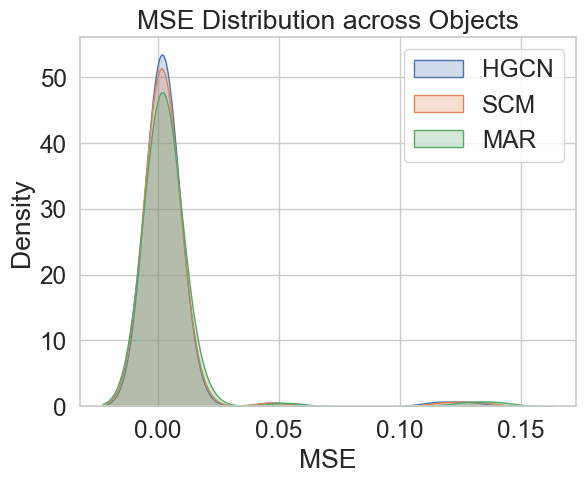

In [275]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.kdeplot(hg_mse, label='HGCN', fill=True)
sns.kdeplot(scm_mse, label='SCM', fill=True)
sns.kdeplot(mar_mse, label='MAR', fill=True)
plt.legend()
plt.xlabel("MSE")
plt.title("MSE Distribution across Objects")
plt.savefig(f"results/_img/{category}/subj_kde.svg", format="svg")
plt.show()


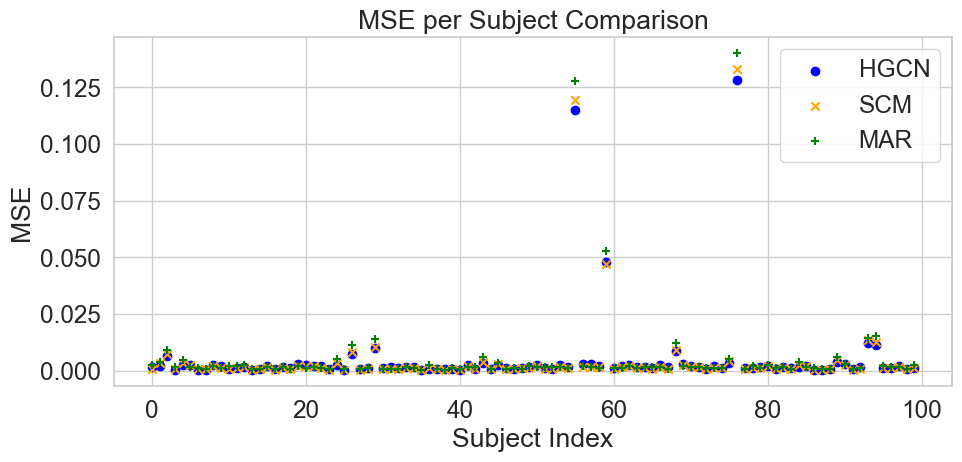

In [276]:
import matplotlib.pyplot as plt

x = range(len(hg_mse))

plt.figure(figsize=(10, 5))
plt.scatter(x, hg_mse, label="HGCN", color='blue', marker='o')
plt.scatter(x, scm_mse, label="SCM", color='orange', marker='x')
plt.scatter(x, mar_mse, label="MAR", color='green', marker='+')
plt.xlabel("Subject Index")
plt.ylabel("MSE")
plt.title("MSE per Subject Comparison")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/_img/{category}/mse_per_sub.svg", format="svg")
plt.show()


In [277]:
import numpy as np

def import_reg_error(predictor: str, category: str) -> List[str]:
    file_path = f"results/{category}/{predictor}_reg_err.csv"
    
    reg_error_values = np.loadtxt(file_path)
    return reg_error_values

In [278]:
import pandas as pd

regional_errors = {}
regional_errors['HGCN'] = import_reg_error(HG_PRED, category)
regional_errors['SCM'] = import_reg_error(SCM_PRED, category)
regional_errors['MAR'] = import_reg_error(MAR_PRED, category)
errors = pd.DataFrame(regional_errors)

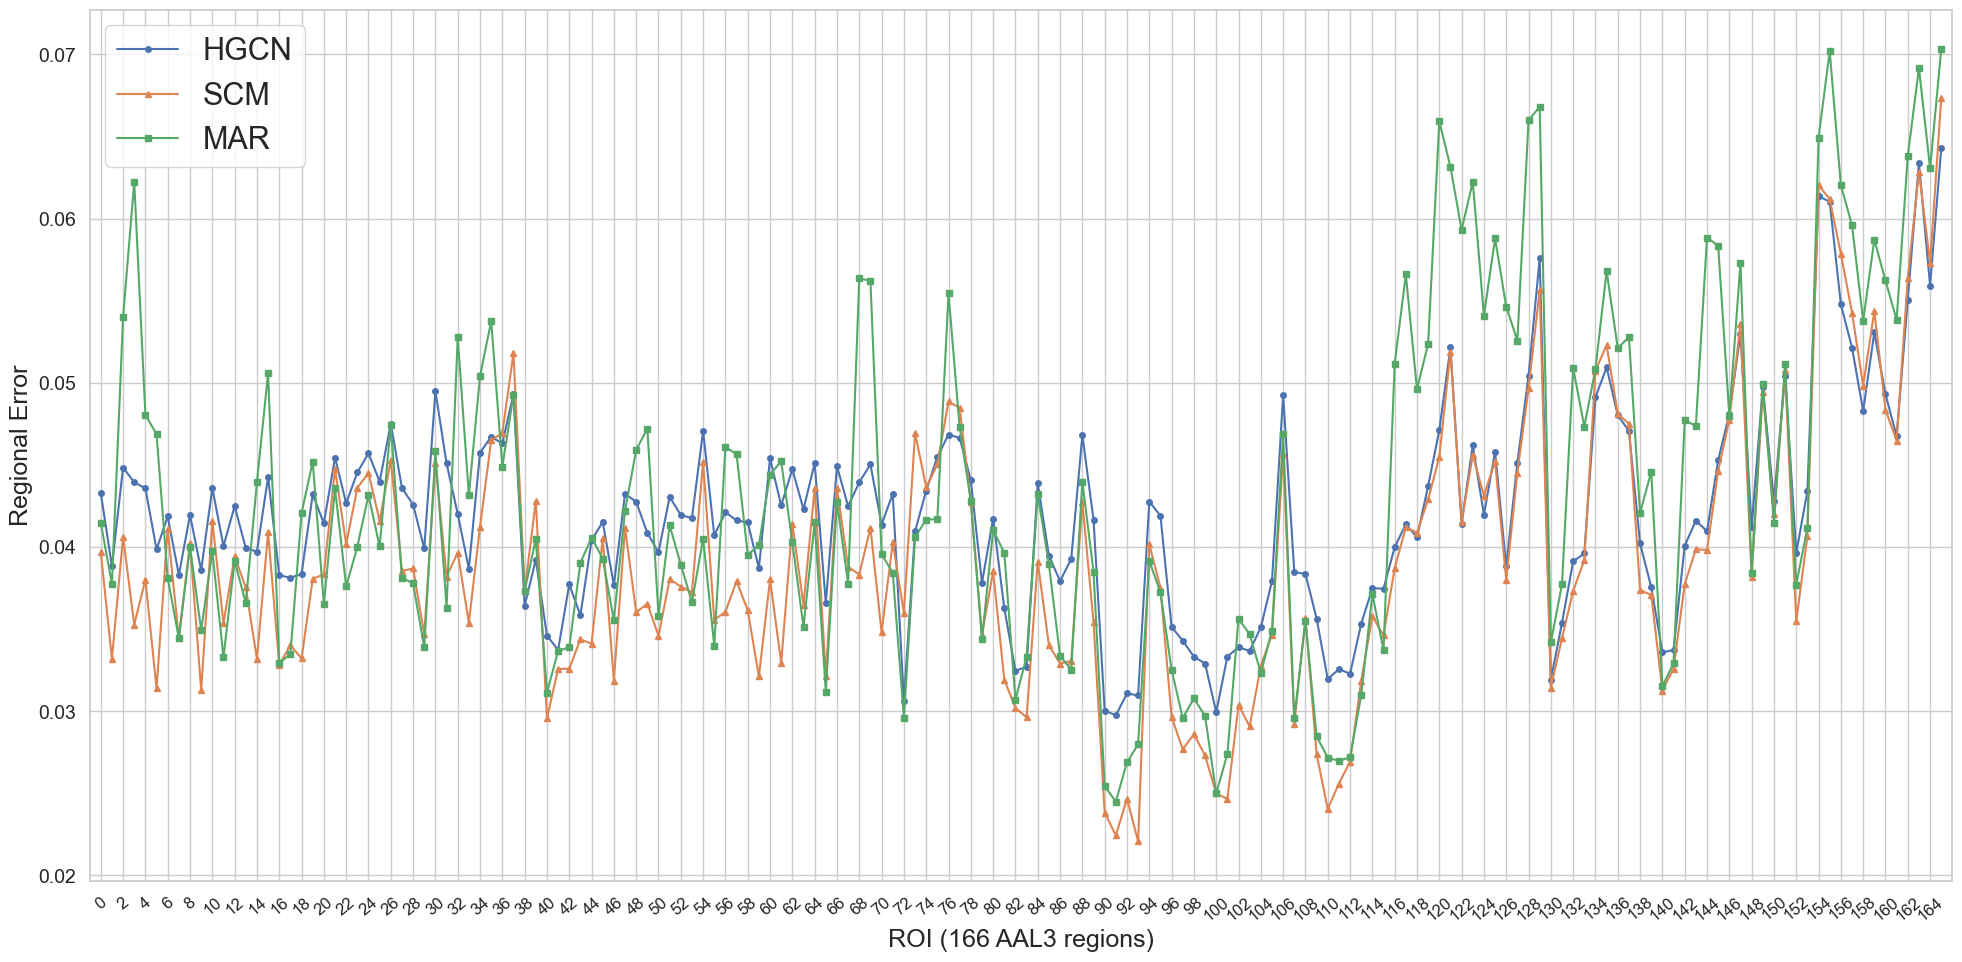

In [279]:

markers = {'HGCN': 'o', 'SCM': '^', 'MAR': 's'}

plt.figure(figsize=(20, 10))
for r in regional_errors.keys():
    plt.plot(errors[r], '-', marker=markers[r], markersize=4, label=r, linewidth=1.5, alpha = 1)

plt.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=22)
plt.ylabel('Regional Error', fontsize=18)
plt.yticks(fontsize=14)
plt.xlim(-1, len(regional_errors['MAR']))
plt.xticks(np.arange(len(regional_errors['MAR']), step=2), fontsize=12, rotation=40)
plt.xlabel('ROI (166 AAL3 regions)', fontsize=18)
plt.grid(True)
plt.tight_layout()
plt.savefig(f"results/_img/{category}/mse_per_reg.svg", format="svg")
plt.show()

In [280]:

labels = []
statistics = []
pvalues = []
test = mannwhitneyu(errors['HGCN'], errors['SCM'], alternative='less', use_continuity=False) 
labels.append('HGCN > SCM')
statistics.append(test.statistic)
pvalues.append(test.pvalue)

test = mannwhitneyu(errors['HGCN'], errors['MAR'], alternative='less', use_continuity=False) 
labels.append('HGCN > MAR')
statistics.append(test.statistic)
pvalues.append(test.pvalue)

test = mannwhitneyu(errors['SCM'], errors['MAR'], alternative='less', use_continuity=False) 
labels.append(' SCM > MAR')
statistics.append(test.statistic)
pvalues.append(test.pvalue)


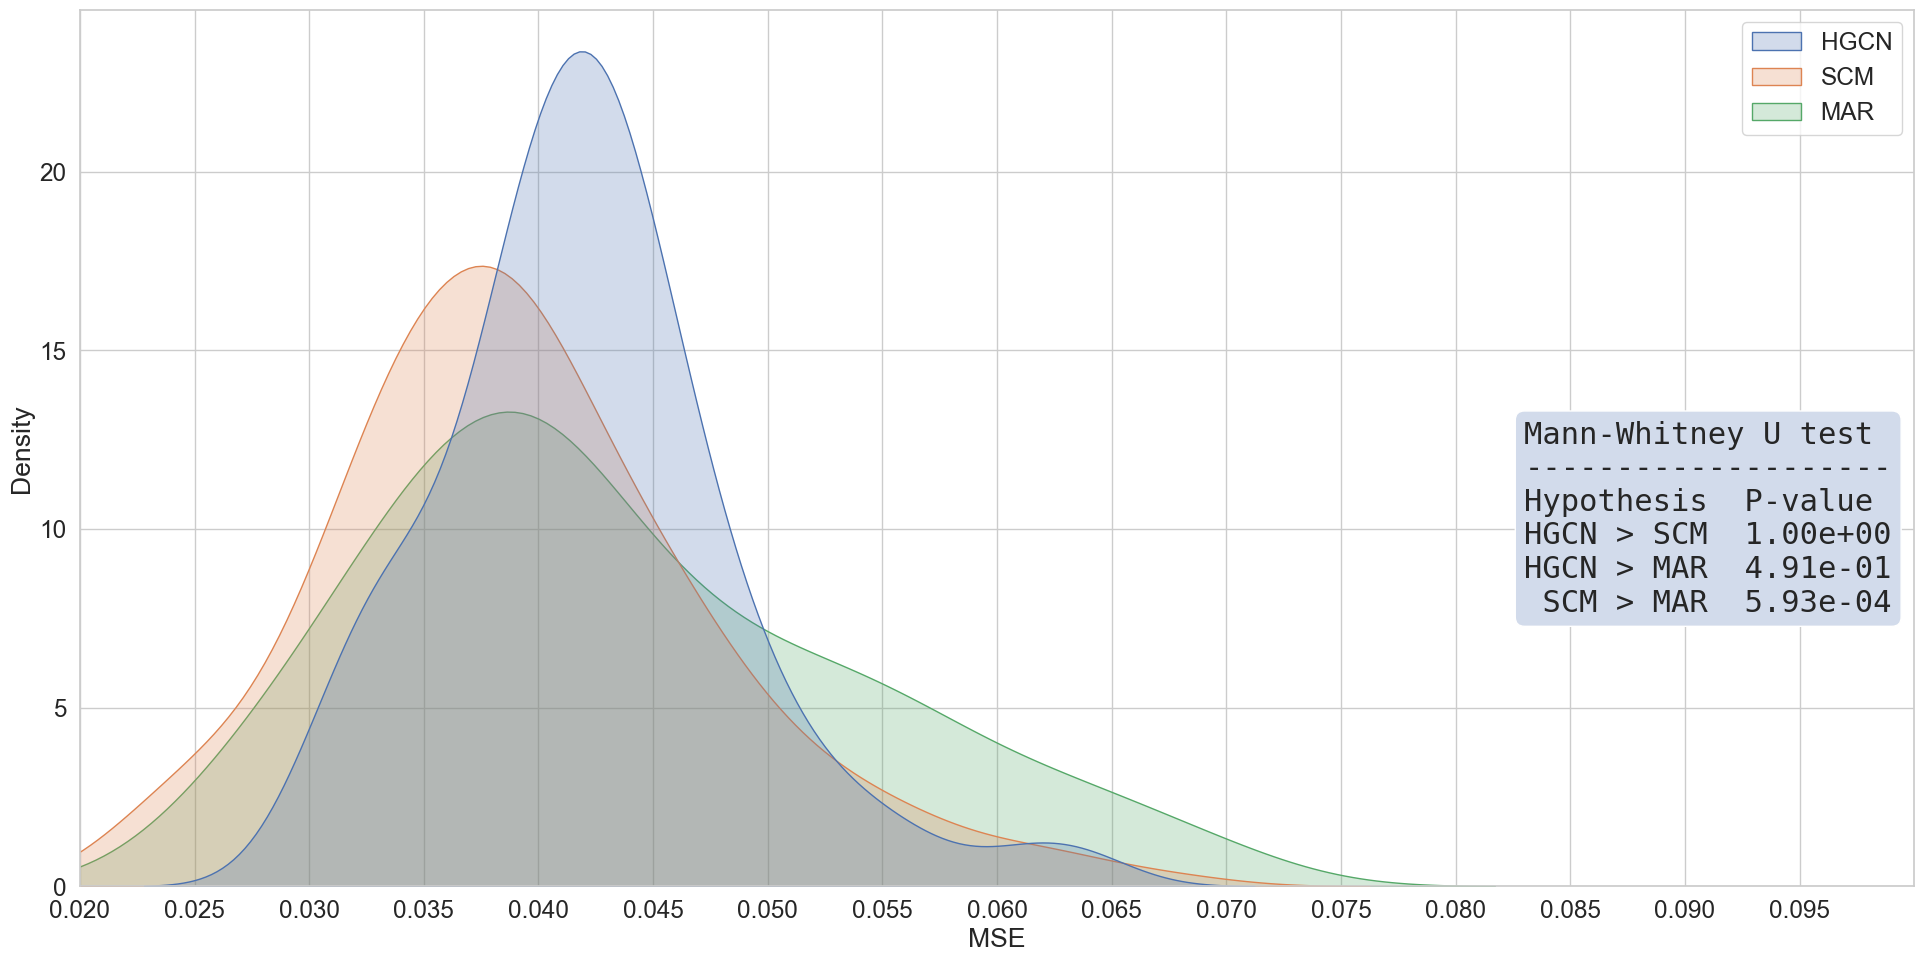

In [281]:
plt.figure(figsize=(20, 10))

sns.set(font_scale=1.6)
sns.set_style("whitegrid")

ax = sns.kdeplot(data=errors, fill=True)
ax.set(xticks=np.arange(0.1, step=0.005), xlim=(0.02, 0.1))
ax.set(xlabel = 'MSE')
text = "Mann-Whitney U test\n--------------------\nHypothesis  P-value\n"
for i in range(len(pvalues)):
    text += labels[i] + '  ' + "{:.2e}".format(pvalues[i])
    if i < len(pvalues) -1 : text+= '\n'
t = plt.text(.083,7.7, text, family='monospace', fontsize=22)
t.set_bbox(dict(boxstyle='Round', facecolor='#d2dbeb', alpha=1))
plt.tight_layout()
plt.grid(True)
plt.savefig(f"results/_img/{category}/reg_kde.svg", format="svg")
plt.show()